# Optimize Thresholds


In [35]:
EXPERIMENT_NAME = 'dataset2_enet_model_bce'
im_size = 300
batch_size = 64
data_path = "/home/sebastian/codes/SensoryCity_working/0_classifier/Split"
resume = f'./{EXPERIMENT_NAME}/model_weights.pth'

In [36]:
import argparse
import sys
import numpy as np
import pandas as pd
import glob
import os

## 1. Improve data format

Addind column with split type, which indicates whether its training, val or testing

In [16]:
output_dir = os.path.join(EXPERIMENT_NAME, "processed_sigmoids")
os.makedirs(output_dir, exist_ok=True)

train_val_files = glob.glob(f"./{EXPERIMENT_NAME}/train_points_BCE.csv") + glob.glob(f"./{EXPERIMENT_NAME}/val_points_BCE.csv")
test_file = glob.glob(f"./{EXPERIMENT_NAME}/test_points_BCE.csv")[0]

df_train_val = pd.concat(
    [pd.read_csv(f).assign(split="trval") for f in train_val_files], 
    ignore_index=True
)

df_test = pd.read_csv(test_file).assign(split="test")

print(f"df_train_val DataFrame: {df_train_val.shape[0]} rows, {df_train_val.columns.tolist()}")
print(f"Test DataFrame: {df_test.shape[0]} rows, {df_test.columns.tolist()}")

df_train_val.to_csv(os.path.join(output_dir, "train_val_data.csv"), index=False)
df_test.to_csv(os.path.join(output_dir, "test_data.csv"), index=False)

print("Data saved successfully in the data_ready folder.")


df_train_val DataFrame: 10261 rows, ['BI', 'GE', 'MH', 'SI', 'TM', 'VM', 'image_name', 'label', 'split']
Test DataFrame: 300 rows, ['BI', 'GE', 'MH', 'SI', 'TM', 'VM', 'image_name', 'label', 'split']
Data saved successfully in the data_ready folder.


In [17]:
df_train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BI          10261 non-null  float64
 1   GE          10261 non-null  float64
 2   MH          10261 non-null  float64
 3   SI          10261 non-null  float64
 4   TM          10261 non-null  float64
 5   VM          10261 non-null  float64
 6   image_name  10261 non-null  object 
 7   label       10261 non-null  object 
 8   split       10261 non-null  object 
dtypes: float64(6), object(3)
memory usage: 721.6+ KB


In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BI          300 non-null    float64
 1   GE          300 non-null    float64
 2   MH          300 non-null    float64
 3   SI          300 non-null    float64
 4   TM          300 non-null    float64
 5   VM          300 non-null    float64
 6   image_name  300 non-null    object 
 7   label       300 non-null    object 
 8   split       300 non-null    object 
dtypes: float64(6), object(3)
memory usage: 21.2+ KB


In [19]:
df_test.head()

,BI,GE,MH,SI,TM,VM,image_name,label,split
0,0.999949,0.000051,1.476193e-07,9.707131e-07,5.164854e-07,4.470614e-08,100_BAM-FS_189.png,BI,test
1,0.999143,0.000673,1.291060e-07,1.834642e-06,4.062265e-08,8.806290e-08,1049_BBI_1233.png,BI,test
2,0.285264,0.800714,8.531752e-06,6.781853e-04,2.160702e-06,1.656652e-05,1364_BBI_268.png,BI,test
3,0.999994,0.000002,6.470057e-09,1.249923e-07,4.612901e-07,1.836168e-09,157_BAM-FS_24.png,BI,test
4,0.999074,0.000330,4.738927e-07,4.126313e-05,5.767634e-06,1.569645e-07,230_BAM-FS_305.png,BI,test


In [20]:
df_test.columns

Index(['BI', 'GE', 'MH', 'SI', 'TM', 'VM', 'image_name', 'label', 'split'], dtype='object')

# 2. Find optimal thresholds

In [21]:
# # check the predictions were actually created 
import pandas as pd
from glob import glob

root = f"./{EXPERIMENT_NAME}/processed_sigmoids"
full_trval_df =  pd.read_csv(os.path.join(root, "train_val_data.csv"))
full_test_df =  pd.read_csv(os.path.join(root, "test_data.csv"))


print(f"df_train_val DataFrame: {df_train_val.shape} rows, {df_train_val.columns}")
print(f"Test DataFrame: {df_test.shape} rows, {df_test.columns}")

df_train_val DataFrame: (10261, 9) rows, Index(['BI', 'GE', 'MH', 'SI', 'TM', 'VM', 'image_name', 'label', 'split'], dtype='object')
Test DataFrame: (300, 9) rows, Index(['BI', 'GE', 'MH', 'SI', 'TM', 'VM', 'image_name', 'label', 'split'], dtype='object')


In [22]:
full_trval_df.head(3)

,BI,GE,MH,SI,TM,VM,image_name,label,split
0,0.999988,0.000014,6.529628e-08,7.184996e-07,3.688868e-07,2.912982e-08,0_BAM-FS_0.png,BI,trval
1,0.999909,0.000039,7.693988e-08,4.859638e-07,3.328132e-08,2.255478e-07,1001_BBI_1190.png,BI,trval
2,0.998542,0.000183,1.322875e-07,5.474196e-05,1.825179e-07,4.966746e-07,1003_BBI_1192.png,BI,trval


In [23]:
labels = full_trval_df.drop(columns=['image_name', 'label', 'split']).columns.tolist()
labels

['BI', 'GE', 'MH', 'SI', 'TM', 'VM']

In [24]:
import os
import shutil
import random
from pathlib import Path
import pandas as pd
from glob import glob
import numpy as np
from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix, roc_auc_score, accuracy_score, cohen_kappa_score, mean_squared_error, precision_recall_fscore_support
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, accuracy_score, cohen_kappa_score
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

Optimizing beta = 0.5
Processing label: BI
              metric    train     test
0           accuracy  0.97486  0.94667
1                AUC  0.98636  0.97000
2          precision  0.95516  0.97222
3             recall  0.86585  0.70000
4              f1_tr  0.90832  0.81395
5               f0.5  0.93585  0.90206
6        specificity  0.99317  0.99600
7  balanced_accuracy  0.92951  0.84800
8              kappa  0.89379  0.78378
9                 th  0.39230  0.39230
Processing label: GE
              metric    train     test
0           accuracy  0.93441  0.94000
1                AUC  0.98341  0.97224
2          precision  0.99750  1.00000
3             recall  0.54323  0.64000
4              f1_tr  0.70339  0.78049
5               f0.5  0.85457  0.89888
6        specificity  0.99977  1.00000
7  balanced_accuracy  0.77150  0.82000
8              kappa  0.67009  0.74766
9                 th  0.95230  0.95230
Processing label: MH
              metric    train     test
0           accura

/tmp/ipykernel_2004775/890273330.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(labels))  # Automatically get distinct colors for each label


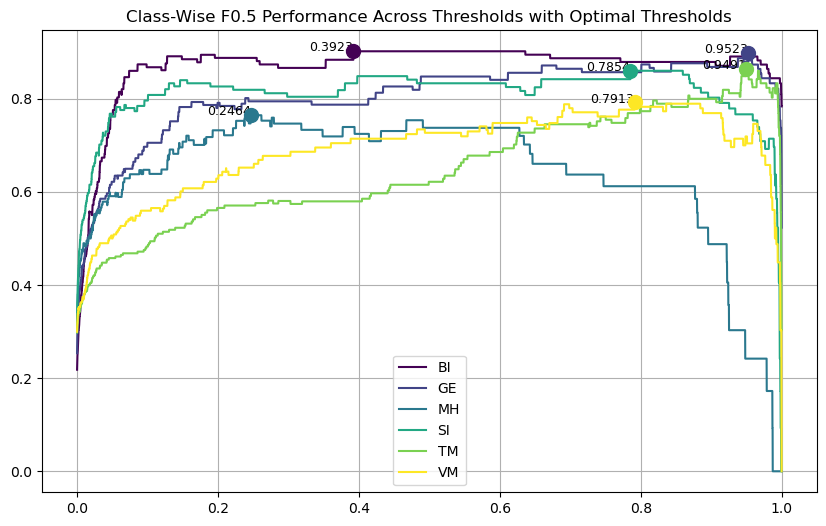

Optimizing beta = 0.75
Processing label: BI
              metric    train     test
0           accuracy  0.96920  0.95667
1                AUC  0.98636  0.97000
2          precision  0.87711  0.91111
3             recall  0.91396  0.82000
4              f1_tr  0.89516  0.86316
5              f0.75  0.89003  0.87607
6        specificity  0.97849  0.98400
7  balanced_accuracy  0.94622  0.90200
8              kappa  0.87712  0.83750
9                 th  0.12780  0.12780
Processing label: GE
              metric    train     test
0           accuracy  0.95342  0.94667
1                AUC  0.98341  0.97224
2          precision  0.95005  0.90476
3             recall  0.71205  0.76000
4              f1_tr  0.81401  0.82609
5              f0.75  0.84801  0.84670
6        specificity  0.99374  0.98400
7  balanced_accuracy  0.85290  0.87200
8              kappa  0.78800  0.79487
9                 th  0.65950  0.65950
Processing label: MH
              metric    train     test
0           accur

/tmp/ipykernel_2004775/890273330.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(labels))  # Automatically get distinct colors for each label


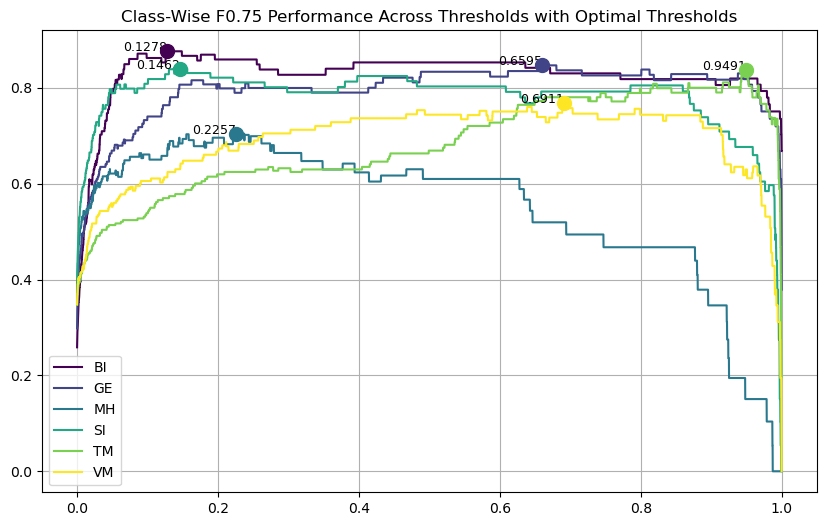

Optimizing beta = 1
Processing label: BI
              metric    train     test
0           accuracy  0.96073  0.95667
1                AUC  0.98636  0.97000
2          precision  0.82339  0.87755
3             recall  0.92547  0.86000
4              f1_tr  0.87145  0.86869
5               f1.0  0.87145  0.86869
6        specificity  0.96665  0.97600
7  balanced_accuracy  0.94606  0.91800
8              kappa  0.84837  0.84274
9                 th  0.08590  0.08590
Processing label: GE
              metric    train     test
0           accuracy  0.94932  0.94000
1                AUC  0.98341  0.97224
2          precision  0.78328  0.76667
3             recall  0.89312  0.92000
4              f1_tr  0.83461  0.83636
5               f1.0  0.83461  0.83636
6        specificity  0.95871  0.94400
7  balanced_accuracy  0.92592  0.93200
8              kappa  0.80483  0.80000
9                 th  0.16240  0.16240
Processing label: MH
              metric    train     test
0           accuracy

/tmp/ipykernel_2004775/890273330.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(labels))  # Automatically get distinct colors for each label


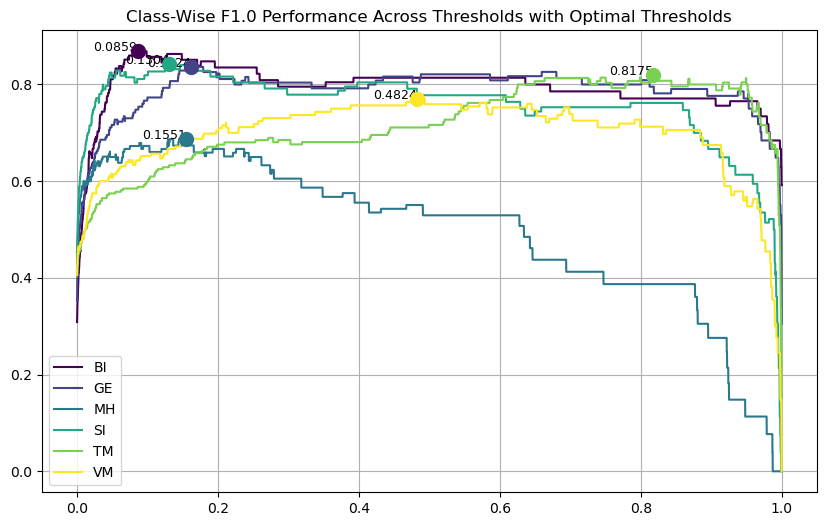

Optimizing beta = 1.25
Processing label: BI
              metric    train     test
0           accuracy  0.96073  0.95667
1                AUC  0.98636  0.97000
2          precision  0.82339  0.87755
3             recall  0.92547  0.86000
4              f1_tr  0.87145  0.86869
5              f1.25  0.88276  0.86676
6        specificity  0.96665  0.97600
7  balanced_accuracy  0.94606  0.91800
8              kappa  0.84837  0.84274
9                 th  0.08590  0.08590
Processing label: GE
              metric    train     test
0           accuracy  0.94932  0.94000
1                AUC  0.98341  0.97224
2          precision  0.78328  0.76667
3             recall  0.89312  0.92000
4              f1_tr  0.83461  0.83636
5              f1.25  0.84678  0.85339
6        specificity  0.95871  0.94400
7  balanced_accuracy  0.92592  0.93200
8              kappa  0.80483  0.80000
9                 th  0.16240  0.16240
Processing label: MH
              metric    train     test
0           accur

/tmp/ipykernel_2004775/890273330.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(labels))  # Automatically get distinct colors for each label


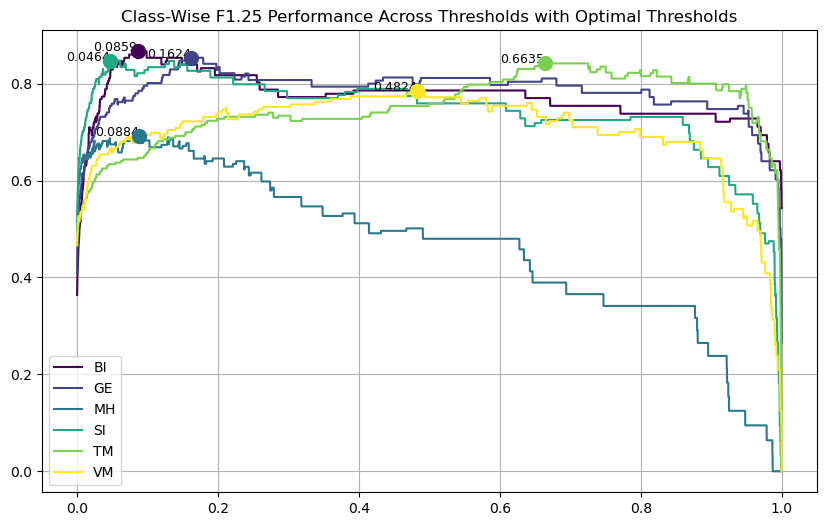

Optimizing beta = 1.5
Processing label: BI
              metric    train     test
0           accuracy  0.96073  0.95667
1                AUC  0.98636  0.97000
2          precision  0.82339  0.87755
3             recall  0.92547  0.86000
4              f1_tr  0.87145  0.86869
5               f1.5  0.89147  0.86533
6        specificity  0.96665  0.97600
7  balanced_accuracy  0.94606  0.91800
8              kappa  0.84837  0.84274
9                 th  0.08590  0.08590
Processing label: GE
              metric    train     test
0           accuracy  0.94932  0.94000
1                AUC  0.98341  0.97224
2          precision  0.78328  0.76667
3             recall  0.89312  0.92000
4              f1_tr  0.83461  0.83636
5               f1.5  0.85618  0.86667
6        specificity  0.95871  0.94400
7  balanced_accuracy  0.92592  0.93200
8              kappa  0.80483  0.80000
9                 th  0.16240  0.16240
Processing label: MH
              metric    train     test
0           accura

/tmp/ipykernel_2004775/890273330.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(labels))  # Automatically get distinct colors for each label


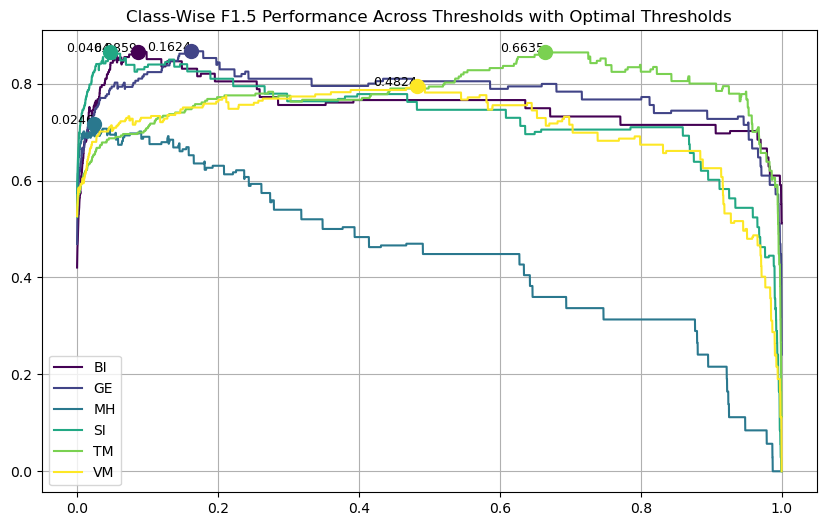

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, cohen_kappa_score

# List of betas
betas = [0.5, 0.75, 1, 1.25, 1.50]

for b in betas:
    print(f"Optimizing beta = {b}")
    b_num = float(b)  # Convert beta string to float for calculations

    # Where results will be saved in this loop
    out_dir = f"./{root}/results/performance_fscore_{str(b_num)}/"
    os.makedirs(out_dir, exist_ok=True)  # Create output directory if it doesn't exist

    # Lists to hold final thresholds and threshold metrics
    final_thresh_ls = []
    threshold_ls = []

    for target_label in labels:
        print(f"Processing label: {target_label}")

        # Subset current label DataFrame
        tr_df = full_trval_df[[f"{target_label}", "label"]]
        test_df = full_test_df[[f"{target_label}", "label"]]

        # Extract predicted probability values
        pred_prob_vec = test_df[f"{target_label}"]
        pred_prob_vec_tr = tr_df[f"{target_label}"]

        # One-hot encode test labels for the current label
        ts_y_ohe = (test_df['label'].str.lower() == target_label.lower()).astype(int)
        tr_y_ohe = (tr_df['label'].str.lower() == target_label.lower()).astype(int)

        # Threshold optimization
        thresh_dt_list = []

        tsearch = pd.Series(range(1, 10000)) / 10000  # Incremental steps to find the best threshold
        for t in tsearch:
            pred_class = (pred_prob_vec >= t).astype(int)  # Binarize based on threshold t
        
            # Calculating confusion matrix elements
            a = sum((pred_class == 1) & (ts_y_ohe == 1))  # True Positive
            b = sum((pred_class == 1) & (ts_y_ohe == 0))  # False Positive
            c = sum((pred_class == 0) & (ts_y_ohe == 1))  # False Negative
            d = sum((pred_class == 0) & (ts_y_ohe == 0))  # True Negative
        
            # Calculate metrics
            precision = a / (a + b) if (a + b) > 0 else 0
            recall = a / (a + c) if (a + c) > 0 else 0
            specificity = d / (d + b) if (d + b) > 0 else 0
            fscore = (1 + b_num**2) * ((precision * recall) / ((b_num**2 * precision) + recall)) if (precision + recall) > 0 else 0
            f1 = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0
            balanced_accuracy = (recall + specificity) / 2
            kappa = cohen_kappa_score(pred_class, ts_y_ohe)
            accuracy = (a + d) / (a + b + c + d) if (a + b + c + d) > 0 else 0
            auc = roc_auc_score(ts_y_ohe, pred_prob_vec)  # Ensure using predicted probabilities
        
            # Save threshold and metrics to list
            thresh_dt_list.append({
                'threshold': t, 'accuracy': accuracy, 'AUC': auc, 'precision': precision, 'recall': recall, 
                f"f{str(b_num)}": fscore, 'f1': f1, 'specificity': specificity, 
                'balanced_accuracy': balanced_accuracy, 'kappa': kappa
            })
        
        thresh_dt = pd.DataFrame(thresh_dt_list)
        
        # Select maximum fbeta value and its threshold
        final_thresh = thresh_dt.loc[thresh_dt[f"f{str(b_num)}"].idxmax()]
        pred_class_vec = (pred_prob_vec >= final_thresh['threshold']).astype(int)  # Classes based on optimized threshold
        
        # Create confusion matrix for train data
        a_tr = sum(((pred_prob_vec_tr >= final_thresh['threshold']).astype(int) == 1) & (tr_y_ohe == 1))  # True Positive
        b_tr = sum(((pred_prob_vec_tr >= final_thresh['threshold']).astype(int) == 1) & (tr_y_ohe == 0))  # False Positive
        c_tr = sum(((pred_prob_vec_tr >= final_thresh['threshold']).astype(int) == 0) & (tr_y_ohe == 1))  # False Negative
        d_tr = sum(((pred_prob_vec_tr >= final_thresh['threshold']).astype(int) == 0) & (tr_y_ohe == 0))  # True Negative
        
        # Calculate training metrics
        precision_tr = a_tr / (a_tr + b_tr) if (a_tr + b_tr) > 0 else 0
        recall_tr = a_tr / (a_tr + c_tr) if (a_tr + c_tr) > 0 else 0
        specificity_tr = d_tr / (d_tr + b_tr) if (d_tr + b_tr) > 0 else 0
        f1_tr = 2 * ((precision_tr * recall_tr) / (precision_tr + recall_tr)) if (precision_tr + recall_tr) > 0 else 0
        fscore_tr = (1 + b_num**2) * ((precision_tr * recall_tr) / ((b_num**2 * precision_tr) + recall_tr)) if (precision_tr + recall_tr) > 0 else 0
        balanced_accuracy_tr = (recall_tr + specificity_tr) / 2
        kappa_tr = cohen_kappa_score((pred_prob_vec_tr >= final_thresh['threshold']).astype(int), tr_y_ohe)
        accuracy_tr = (a_tr + d_tr) / (a_tr + b_tr + c_tr + d_tr) if (a_tr + b_tr + c_tr + d_tr) > 0 else 0
        auc_tr = roc_auc_score(tr_y_ohe, pred_prob_vec_tr)  # Ensure using predicted probabilities for training data
        
        # Save the results to CSV, including the threshold ('th')
        out_ConfMat = pd.DataFrame({
            "metric": ["accuracy", "AUC", "precision", "recall", "f1_tr", f"f{str(b_num)}", "specificity", "balanced_accuracy", "kappa", "th"],
            "train": [f"{accuracy_tr:.5f}", f"{auc_tr:.5f}", f"{precision_tr:.5f}", f"{recall_tr:.5f}", f"{f1_tr:.5f}", f"{fscore_tr:.5f}", f"{specificity_tr:.5f}", f"{balanced_accuracy_tr:.5f}", f"{kappa_tr:.5f}", f"{final_thresh['threshold']:.5f}"],
            "test": [f"{final_thresh['accuracy']:.5f}", f"{final_thresh['AUC']:.5f}", f"{final_thresh['precision']:.5f}", f"{final_thresh['recall']:.5f}", f"{final_thresh['f1']:.5f}", f"{final_thresh[f'f{str(b_num)}']:.5f}", f"{final_thresh['specificity']:.5f}", f"{final_thresh['balanced_accuracy']:.5f}", f"{final_thresh['kappa']:.5f}", f"{final_thresh['threshold']:.5f}"]
        })
        out_ConfMat.to_csv(os.path.join(out_dir, f"{target_label}_model_acc_metrics.csv"), index=False)
        print(out_ConfMat)
        # Append final thresholds and metrics to lists
        thresh_dt['label'] = target_label  # Add label column
        threshold_ls.append(thresh_dt)     # Append the modified DataFrame
        final_thresh_ls.append(final_thresh)
        
    threshold_df = pd.concat(threshold_ls, ignore_index=True)
    final_thresholds = pd.DataFrame(final_thresh_ls)
    final_thresholds['label'] = [label for label in labels for _ in range(len(final_thresholds)//len(labels))]
    
    colors = plt.cm.get_cmap('viridis', len(labels))  # Automatically get distinct colors for each label
    plt.figure(figsize=(10, 6))
    for i, label in enumerate(labels):
        subset = threshold_df[threshold_df.label == label]
        plt.plot(subset['threshold'], subset[f'f{str(b_num)}'], label=label, color=colors(i))
        
        # Add a filled circle with the same color as the plot for each label's threshold
        final_thresh_row = final_thresholds[final_thresholds['label'] == label].iloc[0]
        print(f"Plotting now class {label} with threshold {final_thresh_row['threshold']}")
        plt.scatter(final_thresh_row['threshold'], final_thresh_row[f'f{str(b_num)}'], 
                    color=colors(i), s=100, zorder=5)  # Filled circle with the class color
        
        # Annotate with threshold value
        plt.text(final_thresh_row['threshold'], final_thresh_row[f'f{str(b_num)}'], f'{final_thresh_row["threshold"]:.4f}', fontsize=9, ha='right', color='black')
    plt.title(f"Class-Wise F{str(b_num)} Performance Across Thresholds with Optimal Thresholds", fontsize=12)
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(out_dir, f"fscore{str(b_num)}_performance_across_thresholds.png"))
    plt.savefig(os.path.join(out_dir, f"fscore{str(b_num)}_performance_across_thresholds.pdf"), format='pdf', dpi=300)
    plt.show()
    final_thresholds

# 3. Get thresholds

In [37]:
root

'./dataset2_enet_model_bce/processed_sigmoids'

In [38]:
import os
import pandas as pd

# Root directory where performance folders are located
beta = 0.5  # Set the desired beta level without any slashes
beta = float(beta)
# Dynamically build the directory path based on the beta
data_dir = os.path.join(f"{root}/results", f'performance_fscore_{str(beta)}')
os.makedirs(data_dir, exist_ok = True)
# Retrieve CSV files in the specified beta folder
csv_files = [file for file in os.listdir(data_dir) if file.endswith("model_acc_metrics.csv")]
if not csv_files:
    raise FileNotFoundError(f"No 'model_acc_metrics.csv' files found in {data_dir}.")

print(csv_files)
# Load CSVs with added label
dataframes = []
for csv_file in csv_files:
    df = pd.read_csv(os.path.join(data_dir, csv_file))
    label = os.path.basename(csv_file).split("_")[0]  # Extract label from filename
    df['label'] = label
    dataframes.append(df)

# Combine all data into one DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df

['MH_model_acc_metrics.csv', 'VM_model_acc_metrics.csv', 'SI_model_acc_metrics.csv', 'BI_model_acc_metrics.csv', 'TM_model_acc_metrics.csv', 'GE_model_acc_metrics.csv']


,metric,train,test,label
0,accuracy,0.94084,0.90667,MH
1,AUC,0.96547,0.93704,MH
2,precision,0.72997,0.86667,MH
3,recall,0.68843,0.52000,MH
4,f1_tr,0.70859,0.65000,MH
5,f0.5,0.72127,0.76471,MH
6,specificity,0.97029,0.98400,MH
7,balanced_accuracy,0.82936,0.75200,MH
8,kappa,0.67571,0.60000,MH
9,th,0.24640,0.24640,MH


In [39]:
data_dir

'./dataset2_enet_model_bce/processed_sigmoids/results/performance_fscore_0.5'

In [40]:
# Printing Unique Metrics
unique_metrics = combined_df['metric'].unique()
print("Unique metrics available in the DataFrame:")
print(unique_metrics)

# Calculating and Printing Metrics
summary = []  # List to store the summary for each metric
thresholds = []  # List to store thresholds and their associated labels

for metric in unique_metrics:
    # Filter the DataFrame for the current metric
    metric_data = combined_df[combined_df['metric'] == metric]
    
    # Select the 'test' and 'label' columns
    test_data = metric_data[['test', 'label']]
    
    # Calculate the mean of the 'test' values
    mean_test = test_data['test'].mean()
    
    # Append the results to the summary
    summary.append({'metric': metric, 'means': mean_test})
    
    if metric == 'th':
        thresholds.extend(metric_data[['test', 'label']].to_dict('records'))

# Convert summary into a DataFrame for better presentation
summary_df = pd.DataFrame(summary)
summary_df.to_csv(f'./{data_dir}/summary_metrics_beta{str(beta)}.csv', index=False)

thresholds_df = pd.DataFrame(thresholds)

thresholds_df.rename(columns={'test': 'value'}, inplace=True)
thresholds_df = thresholds_df[["label","value"]]

print("\nSummary of metrics (mean test values):")
summary_df

Unique metrics available in the DataFrame:
['accuracy' 'AUC' 'precision' 'recall' 'f1_tr' 'f0.5' 'specificity'
 'balanced_accuracy' 'kappa' 'th']

Summary of metrics (mean test values):


,metric,means
0,accuracy,0.931667
1,AUC,0.963640
2,precision,0.920770
3,recall,0.646667
4,f1_tr,0.757800
5,f0.5,0.847073
6,specificity,0.988667
7,balanced_accuracy,0.817667
8,kappa,0.719633
9,th,0.686133


In [41]:
print("\nIndividual Thresholds DataFrame (before averaging):")
thresholds_df.to_csv(f'./{data_dir}/summary_thr_beta{str(beta)}.csv', index=False)
thresholds_df


Individual Thresholds DataFrame (before averaging):


,label,value
0,MH,0.2464
1,VM,0.7913
2,SI,0.7854
3,BI,0.3923
4,TM,0.9491
5,GE,0.9523


# Check thresholds on testing data. 

In [42]:
# Root directory where performance folders are located

results = os.path.join(f"{root}/results_b{str(beta)}")
os.makedirs(results,exist_ok=True)
print(results)
# Dynamically build the directory path based on the beta
optimal_thresholds = os.path.join(f"./{root}/results", f'performance_fscore_{str(beta)}/summary_thr_beta{str(beta)}.csv')
optimal_thresholds = pd.read_csv(optimal_thresholds)
optimal_thresholds

./dataset2_enet_model_bce/processed_sigmoids/results_b0.5


,label,value
0,MH,0.2464
1,VM,0.7913
2,SI,0.7854
3,BI,0.3923
4,TM,0.9491
5,GE,0.9523


In [64]:
import argparse
import sys
import torch
import os
import argparse
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import time
from tqdm import tqdm
from sklearn.metrics import fbeta_score

from net.metrics import *
from net.models import *


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


args = argparse.Namespace()

def get_args_parser():
    parser = argparse.ArgumentParser(description="Train and test a model with folder-based data structure.")
    parser.add_argument('--experiment_name', type=str, default=experiment_name)
    parser.add_argument('--resume', type=str, default=experiment_name)
    parser.add_argument('--im_size', type=tuple, default=im_size)
    parser.add_argument('--batch_size', type=int, default=batch_size)
    parser.add_argument('--data_path', type=str, default=data_path)
    parser.add_argument('--file_name', default=file_name, type=str, help='file_name')
    return parser

def parse_args():
    global args
    parser = get_args_parser()
    if 'ipykernel' in sys.modules:
        args, unknown = parser.parse_known_args(namespace=args)
    else:
        args = parser.parse_args(namespace=args)
    return args

args = parse_args()
print(args)

specific_path = os.path.join(args.data_path, file_name)
no_aug_transform = transforms.Compose([
        transforms.Resize(args.im_size),
        transforms.CenterCrop(args.im_size),
        transforms.ToTensor()
])
specific_dataset = datasets.ImageFolder(root=specific_path, transform=no_aug_transform)
specific_dataloader = DataLoader(specific_dataset, batch_size=args.batch_size, shuffle=False)
num_classes = len(specific_dataset.classes)
class_names = specific_dataset.classes
class_names

Namespace(experiment_name='enet_model_bce', resume='enet_model_bce', im_size=300, batch_size=64, data_path='/home/sebastian/codes/SensoryCity_working/0_classifier/Split', file_name='test')


['BI', 'GE', 'MH', 'SI', 'TM', 'VM']

In [65]:
model = load_model(resume, num_classes, device)

In [66]:

def evaluate_test_bce_new(data_loader, model, device,class_names, experiment_name, phase):
    @torch.no_grad()
    def inner_evaluate(phase="training"):
        model.eval()
        class_names = data_loader.dataset.classes
        num_classes  = len(class_names)
        print(f"Evaluating over {num_classes} classes: {class_names}")
        all_predictions = []
        all_labels = []
        all_image_names = []
        inference_times = []
        output_probs_list = []
        
        for batch_idx, batch in enumerate(data_loader):
            images = batch[0]
            target = batch[-1]

            image_names_batch = [
                    os.path.basename(data_loader.dataset.imgs[i][0])  # Extract the filename from the full path
                    for i in range(len(target))
            ]
            
            all_image_names.extend(image_names_batch)  

            images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)

            start_time = time.time()
            # with torch.cuda.amp.autocast():
            with torch.no_grad():
                output = model(images)
                target = torch.nn.functional.one_hot(target, num_classes=num_classes).float()
            
            all_labels.append(target.cpu().numpy())
            output_probs = torch.sigmoid(output)  # Use sigmoid instead of softmax for multi-label https://github.com/CQuinn8/ABGQI-CNN/blob/v.1.0.2/2_cnn_inference-py/code/0_CNN_inference.ipynb
            output_probs_list.append(output_probs.cpu().numpy())
            inference_times.append(time.time() - start_time)
        
        # Flatten predictions and labels
        all_labels = np.concatenate(all_labels, axis=0)
        output_probs = np.concatenate(output_probs_list, axis=0)
        
        predictions_df = pd.DataFrame(output_probs, columns=class_names)
        predictions_df['image_name'] = all_image_names 
        
        return all_labels, output_probs, predictions_df
    
    all_labels, output_probs, predictions_df = inner_evaluate(phase)
    
    return all_labels, output_probs, predictions_df
def apply_threshold(row, threshold_dict):
    label = row['label']
    threshold = threshold_dict.get(label, 0.5)  # Default threshold is 0.5 if label not found
    probabilities = row[class_names]
    predicted_class = (probabilities >= threshold).astype(int)  # Apply threshold to each probability
    return predicted_class


In [70]:
all_labels

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1.

In [73]:
all_labels, output_probs, predictions_df = evaluate_test_bce_new(specific_dataloader, model, device,class_names, experiment_name, file_name)

all_labels_indices = np.argmax(all_labels, axis=1)
# predictions_df = pd.DataFrame(output_probs, columns=class_names)

predictions_df['label'] = [class_names[label] for label in all_labels_indices]
threshold_dict = dict(zip(optimal_thresholds['label'], optimal_thresholds['value']))

# hot_encoded_preds = predictions_df.apply(lambda row: apply_threshold(row, threshold_dict), axis=1)
# Empty list to hold the new one-hot encoded predictions
new_preds = []

# Loop through each row and apply thresholds
for index, row in predictions_df.iterrows():
    # Get the class label for this row
    label = row['label']
    thr = threshold_dict[label]
    
    # Initialize the one-hot encoded prediction for this row
    one_hot_row = {class_name: 0 for class_name in threshold_dict}
    
    # Manually compare each class prediction against its threshold
    for class_name in threshold_dict:
        if row[class_name] >= threshold_dict[class_name]:
            one_hot_row[class_name] = 1
    
    # Append the one-hot encoded row to the list
    new_preds.append(one_hot_row)

# Convert the new predictions into a DataFrame
hot_encoded_preds = pd.DataFrame(new_preds)

hot_encoded_preds = hot_encoded_preds[class_names]
hot_encoded_preds['image_name'] = predictions_df['image_name']
hot_encoded_preds.to_csv(f"{results}/sigmoid_preds_beta{str(beta)}.csv", index=True)
hot_encoded_preds['label'] = predictions_df['label']
hot_encoded_preds

hot_encoded_preds


Evaluating over 6 classes: ['BI', 'GE', 'MH', 'SI', 'TM', 'VM']


,BI,GE,MH,SI,TM,VM,image_name,label
0,1,0,0,0,0,0,100_BAM-FS_189.png,BI
1,1,0,0,0,0,0,1049_BBI_1233.png,BI
2,0,0,0,0,0,0,1364_BBI_268.png,BI
3,1,0,0,0,0,0,157_BAM-FS_24.png,BI
4,1,0,0,0,0,0,230_BAM-FS_305.png,BI
...,...,...,...,...,...,...,...,...
295,0,0,0,0,0,1,SQC_57_P2_111.png,VM
296,0,0,0,0,0,1,SQC_57_P3_22.png,VM
297,0,0,0,0,0,0,SQC_8_P2_69.png,VM
298,0,0,0,0,0,1,VNE_33_P2_69.png,VM


In [74]:
predictions_df['label']

0      BI
1      BI
2      BI
3      BI
4      BI
       ..
295    VM
296    VM
297    VM
298    VM
299    VM
Name: label, Length: 300, dtype: object

In [76]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Initialize a dictionary to hold metrics
class_metrics = {}

# Iterate over each class to calculate metrics
for label in class_names:
    # Get the true labels (multi-hot encoded) for the current label
    true_labels = (all_labels[:, class_names.index(label)] == 1).astype(int)
    
    # Get the predicted labels (after applying thresholds)
    predicted_labels = hot_encoded_preds[label]
    
    # Calculate confusion matrix for the current label (binary)
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

    # Compute metrics for the current class
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity = TN / (TN + FP)
    
    # Calculate the F-beta score
    fbeta = fbeta_score(true_labels, predicted_labels, beta=beta)
    
    # Calculate the AUC score (Area Under the Curve)
    auc = roc_auc_score(true_labels, predicted_labels)
    
    # Store the metrics in the dictionary
    class_metrics[label] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "fbeta_score": fbeta,  # Add the F-beta score
        "specificity": specificity,
        "auc": auc,  # Add the AUC score
        "confusion_matrix": (tn, fp, fn, tp)
    }

# Convert the metrics to a DataFrame for better presentation
metrics_df = pd.DataFrame(class_metrics).T  # Transpose to have labels as rows
metrics_df = metrics_df[['accuracy', 'precision', 'recall', 'f1_score', 'fbeta_score', 'specificity','auc']]

# Calculate the average of each metric across all classes
average_metrics = metrics_df.mean()

# Append the average row to the DataFrame
metrics_df.loc['average'] = average_metrics

# Save the results to a CSV file
metrics_df.to_csv(f"{results}/class_metrics_with_beta{str(beta)}.csv", index=True)

# Display the metrics DataFrame
metrics_df

,accuracy,precision,recall,f1_score,fbeta_score,specificity,auc
BI,0.946667,0.972222,0.7,0.813953,0.902062,0.996,0.848
GE,0.94,1.0,0.64,0.780488,0.898876,1.0,0.82
MH,0.906667,0.866667,0.52,0.65,0.764706,0.984,0.752
SI,0.933333,0.941176,0.64,0.761905,0.860215,0.992,0.816
TM,0.943333,0.902439,0.74,0.813187,0.864486,0.984,0.862
VM,0.92,0.842105,0.64,0.727273,0.792079,0.976,0.808
average,0.931667,0.920768,0.646667,0.757801,0.847071,0.988667,0.817667


In [77]:
int(beta)

0

In [ ]:
optimal_thresholds